In [5]:
import pandas as pd
import numpy as np
import os, sys
import warnings
import random

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# f = os.path.dirname(__file__)
sys.path.append(os.path.join(os.getcwd(), "../.."))
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, auc, roc_curve, \
    balanced_accuracy_score, precision_recall_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression
from detection.detection_utils.factory import create_dir_if_missing
from config.detection_config import user_level_execution_config, user_level_conf, post_level_execution_config

sns.set(rc={'figure.figsize': (10, 10)}, font_scale=1.4)
from scipy.optimize import minimize
from utils.my_timeit import timeit
from utils.general import init_log

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=0, **optuna.samplers.TPESampler.hyperopt_parameters())

logger = init_log("user_level_simple_models")

def expect_f1(y_true, y_prob, thres):
    idxs = np.where(y_prob >= thres)[0]
    tp = y_prob[idxs].sum()
    fp = len(idxs) - tp
    idxs = np.where(y_prob < thres)[0]
    fn = y_prob[idxs].sum()
    return 2*tp / (2*tp + fp + fn)

def optimal_threshold(y_true, y_prob):
    y_prob = np.sort(y_prob)[::-1]
    f1s = [expect_f1(y_true, y_prob, p) for p in y_prob]
    thres = y_prob[np.argmax(f1s)]
    return thres #, f1s 

def get_hs_count(current_preds, threshold=0.5):
    return len(current_preds[current_preds >= threshold])

os.chdir('/sise/home/tommarz/hate_speech_detection/')
os.getcwd()

'/sise/home/tommarz/hate_speech_detection'

# Fixed Threshold Method

In [2]:
def fixed_threshold_method(X: pd.DataFrame, y: pd.Series, post_threshold=0.5, test_ratio=0.2, random_state=None, min_post_th=1, max_post_th=300):
    
    y_train, y_test = train_test_split(y, test_size=0.2, random_state=random_state, stratify=y)
    X_train = X[X['user_id'].isin(y_train.index)]
    X_test = X[X['user_id'].isin(y_test.index)]
    print(f'Train Percent HS Users: {y_train.mean()}')
    print(f'Test Percent HS Users: {y_test.mean()}')
    
    args = [post_threshold]
    train_hs_count_df = X_train.groupby('user_id').predictions.agg(get_hs_count, *args)
    min_num_of_posts_thresholds = range(max(min_post_th, train_hs_count_df.min()), min(max_post_th, train_hs_count_df.max())+1)
    
    train_preds = np.expand_dims(train_hs_count_df, axis=1) >= min_num_of_posts_thresholds
    train_f1_scores = [f1_score(y_train, p) for p in train_preds.T]
    best_f1_train, best_th = np.max(train_f1_scores), min_num_of_posts_thresholds[np.argmax(train_f1_scores)]
    
    test_hs_count_df = X_test.groupby('user_id').predictions.agg(get_hs_count, *args)
    test_preds = test_hs_count_df >= best_th
    train_preds = train_hs_count_df >= best_th
    test_f1_score = f1_score(y_test, test_preds)
    
    return best_th, best_f1_train, test_f1_score

In [3]:
post_threshold = optimal_threshold(y_true, y_prob)
fixed_threshold_method(X, y, post_threshold=post_threshold, test_ratio=0.2)

NameError: name 'y_true' is not defined

# Relational Threshold Method

## Grid Search

In [297]:
a = np.linspace(0, 1, 11)
params = np.array(np.meshgrid(a, a, a)).T.reshape(-1,3)
# params = np.column_stack((a,a,a))
param_grid = params[params.sum(axis=1)==1]
param_grid.shape

(62, 3)

In [298]:
test_ratio = 0.2
random_state = 42
min_mentions_threshold = 3
min_retweets_threshold = 5

In [299]:
network_dir = f"hate_networks/outputs/{dataset.split('_')[0]}_networks/network_data/"
edges_dir = os.path.join(network_dir, "edges")
mentions_df = pd.read_csv(os.path.join(edges_dir, "data_users_mention_edges_df.tsv"), sep='\t')
retweets_df = pd.read_csv(os.path.join(edges_dir, "data_users_retweet_edges_df.tsv"), sep='\t')
y_train, y_test = train_test_split(y, test_size=test_ratio, random_state=random_state, stratify=y)

In [300]:
filtered_mentions_df = mentions_df.query('`weight`>=@min_mentions_threshold') #.drop(columns=['weight'])
filtered_retweets_df = retweets_df.query('`weight`>=@min_retweets_threshold')

In [301]:
tmp = filtered_mentions_df.query('`source` in @y.index or `dest` in @y.index')
tmp['mentioned_hs_count'] = tmp['dest'].map(user_hs_count)
tmp['mentioned_by_hs_count'] = tmp['source'].map(user_hs_count)
tmp['mentioned_mean_preds'] = tmp['dest'].map(user_mean_preds)
tmp['mentioned_by_mean_preds'] = tmp['source'].map(user_mean_preds)
tmp[['weighted_mentioned_hs_count', 'weighted_mentioned_by_hs_count', 'weighted_mentioned_mean_preds', 'weighted_mentioned_by_mean_preds']] = tmp[['mentioned_hs_count', 'mentioned_by_hs_count', 'mentioned_mean_preds', 'mentioned_by_mean_preds']].multiply(tmp["weight"], axis="index")
tmp.fillna(0, inplace=True)
tmp

,source,dest,weight,mentioned_hs_count,mentioned_by_hs_count,mentioned_mean_preds,mentioned_by_mean_preds,weighted_mentioned_hs_count,weighted_mentioned_by_hs_count,weighted_mentioned_mean_preds,weighted_mentioned_by_mean_preds
0,1175,4735,90,186.0,369,0.088122,0.065246,16740.0,33210,7.930986,5.872167
13,1175,1307,22,66.0,369,0.071304,0.065246,1452.0,8118,1.568694,1.435419
16,1175,1843,122,93.0,369,0.071964,0.065246,11346.0,45018,8.779577,7.960048
17,1175,979,15,57.0,369,0.067145,0.065246,855.0,5535,1.007178,0.978694
18,1175,1412,55,148.0,369,0.069431,0.065246,8140.0,20295,3.818683,3.588546
...,...,...,...,...,...,...,...,...,...,...,...
804262,170310,233064,7,25.0,20,0.057226,0.095744,175.0,140,0.400579,0.670210
804348,376715,363699,5,9.0,5,0.097053,0.155195,45.0,25,0.485266,0.775975
804880,381814,251,4,5.0,2,0.066947,0.081958,20.0,8,0.267786,0.327830
806037,131737,233064,4,25.0,13,0.057226,0.095538,100.0,52,0.228902,0.382150


In [302]:
features_df = pd.concat([user_hs_count.loc[y.index], tmp.query('`source` in @y.index').groupby('source').mean()], axis=1).fillna(0).drop(columns=['dest','weight'])
features_df

,hs_count,mentioned_hs_count,mentioned_by_hs_count,mentioned_mean_preds,mentioned_by_mean_preds,weighted_mentioned_hs_count,weighted_mentioned_by_hs_count,weighted_mentioned_mean_preds,weighted_mentioned_by_mean_preds
251,5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
501,4,416.833333,4.0,0.112079,0.064894,2337.500000,22.666667,0.582020,0.367732
766,2,325.666667,2.0,0.086634,0.052865,2154.750000,11.666667,0.486931,0.308377
773,28,83.785714,28.0,0.071930,0.079690,1789.928571,290.000000,0.763962,0.825356
838,6,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
374034,7,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
380071,6,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
381309,9,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
385490,6,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [303]:
cols_to_use = ['hs_count', 'mentioned_hs_count', 'mentioned_by_hs_count']
features_df[cols_to_use]

,hs_count,mentioned_hs_count,mentioned_by_hs_count
251,5,0.000000,0.0
501,4,416.833333,4.0
766,2,325.666667,2.0
773,28,83.785714,28.0
838,6,0.000000,0.0
...,...,...,...
374034,7,0.000000,0.0
380071,6,0.000000,0.0
381309,9,0.000000,0.0
385490,6,0.000000,0.0


In [305]:
tom = np.dot(features_df[cols_to_use], param_grid.T)
tom.shape

(1000, 62)

In [328]:
thresholds = np.linspace(0, round(np.percentile(tom[:, 0], q=75))+1, 50)

In [339]:
thresholds = np.geomspace(1, tom[:, 0].max(), 300)

In [340]:
preds = np.expand_dims(tom[:, 0], axis=-1) >= thresholds
preds.shape

(1000, 300)

In [343]:
kwargs = {'y_true': y}
res = np.apply_along_axis(func1d=lambda y_pred, y_true: f1_score(y_true, y_pred), axis=0, arr=preds, **kwargs)
res.shape

(300,)

In [292]:
f = np.vectorize(lambda y_pred, y_true: f1_score(y_true, y_pred), excluded=[1])

In [344]:
idx = np.unravel_index(res.argmax(), res.shape)

In [349]:
thresholds[idx[0]]

35.32329420121453

In [350]:
res[idx[0]]

0.3514644351464435

## Optuna

In [396]:
def relational_threshold_method(X: pd.DataFrame, y: pd.DataFrame, min_mention_threshold=5, test_ratio=0.2, post_threshold=0.5, random_state=None, min_th=1, max_th=300, n_trials=1000):
    """
    Here we consider the assumption that relation to followers/followees effect the users' behaviour.
    For each user - get his average HS score, and the average HS scores of his followers and followees.
    then search for the optimal relational threshold to yield the best f1-score.
    This threshold will be combined from a self-TH + followers-TH + followees-TH.

    :param X:
    :param y:
    :return:
    """

    network_dir = f"hate_networks/outputs/{dataset.split('_')[0]}_networks/network_data/"
    edges_dir = os.path.join(network_dir, "edges")
    mentions_df = pd.read_csv(os.path.join(edges_dir, "data_users_mention_edges_df.tsv"), sep='\t')
    retweets_df = pd.read_csv(os.path.join(edges_dir, "data_users_retweet_edges_df.tsv"), sep='\t')
    
    y_train, y_test = train_test_split(y, test_size=test_ratio, random_state=random_state, stratify=y)
    filtered_mentions_df = mentions_df[mentions_df["weight"] >= min_mention_threshold].reset_index(drop=True)

    args = [post_threshold]
    user_hs_count = X.query('`user_id` in @y.index').groupby('user_id').predictions.mean().rename('hs_count')
    mentions_hs_count = X.query('`user_id` in @filtered_mentions_df.source').groupby('user_id').predictions.mean().rename('hs_count').reset_index()
    mentioned_by_hs_count =  X.query('`user_id` in @filtered_mentions_df.dest').groupby('user_id').predictions.mean().rename('hs_count').reset_index()

    filtered_mentions_hs_count_df = pd.merge(
        pd.merge(filtered_mentions_df, mentions_hs_count, left_on='source', right_on='user_id', how='left'),
        mentioned_by_hs_count, left_on='dest', right_on='user_id', how='left', suffixes=('_source', '_dest')
    ).fillna(0).astype(int).drop(columns=['source', 'dest', 'weight'])

    following_hs_df = filtered_mentions_hs_count_df.groupby('user_id_source').agg({'hs_count_dest': ['mean', 'count', 'median']})
    following_hs_df.columns = [f'following_hs_{x[1]}' for x in following_hs_df.columns.to_flat_index()]
    followers_hs_df = filtered_mentions_hs_count_df.groupby('user_id_dest').agg({'hs_count_source': ['mean', 'count', 'median']})
    followers_hs_df.columns = [f'followers_hs_{x[1]}' for x in followers_hs_df.columns.to_flat_index()]

    followees_mean_hs_count_df =  filtered_mentions_hs_count_df.groupby('user_id_source')['hs_count_dest'].mean().rename('following_mean_hs_count')
    followers_mean_hs_count_df = filtered_mentions_hs_count_df.groupby('user_id_dest')['hs_count_source'].mean().rename('followers_mean_hs_count')

    user_hs_count_followees_followers_mean_hs_count = pd.merge(
        pd.merge(
            user_hs_count.rename('hs_count'), following_hs_df, left_index=True, right_index=True, how='left'
        ), followers_hs_df, left_index=True, right_index=True, how='left'
    ).fillna(0)

    cols = ['hs_count', 'following_hs_mean', 'followers_hs_mean']
    X_train = user_hs_count_followees_followers_mean_hs_count.loc[y_train.index, cols]
    X_test = user_hs_count_followees_followers_mean_hs_count.loc[y_test.index, cols]

    def objective(trial, X, y):
        self_weight = trial.suggest_float('self_weight', 0, 1)
        followers_weight = trial.suggest_float('followers_weight', 0, 1)
        following_weight = trial.suggest_float('following_weight', 0, 1)
        hs_score = np.dot(X, [self_weight, followers_weight, following_weight])
        threshold = trial.suggest_float('threshold', min_th, max_th)
        preds = hs_score >= threshold
        return f1_score(y, preds)
        
        return get_relational_model_preds(X, y, self_weight, followers_weight, following_weight)

    study = optuna.create_study(direction="maximize", sampler=sampler)  # Create a new study.
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=n_trials, show_progress_bar=True)

    test_hs_score = np.dot(X_test, [study.best_params['self_weight'], study.best_params['followers_weight'], study.best_params['following_weight']])
    preds = test_hs_score >= study.best_params['threshold']
    test_f1 = f1_score(y_test, preds)
    # test_f1 = get_relational_model_preds(X_test, y_test, **study.best_params)
    best_f1 = study.best_value
    print(study.best_params)
    print(best_f1, test_f1)

In [398]:
post_threshold

0.35367036

In [397]:
post_threshold = optimal_threshold(y_true, y_prob)
relational_threshold_method(user2pred, y, post_threshold=post_threshold, min_mention_threshold=9, n_trials=1000)

100%|██████████| 1000/1000 [00:30<00:00, 33.33it/s]

{'self_weight': 0.6267064759591049, 'followers_weight': 0.7275436095907498, 'following_weight': 0.024272704622061214, 'threshold': 129.60467932864523}
0.0 0.0


## ML Model

In [129]:
y_train, y_test = train_test_split(y, test_size=0.2, random_state=None, stratify=y)
class_weight = compute_class_weight(class_weight='balanced', y=y_train, classes=[0,1])
class_weight

array([0.66445183, 2.02020202])

In [311]:
def extract_feats(X, y, min_mentions_threshold, min_retweets_threshold):
    user_mean_preds = X.groupby('user_id').predictions.mean().rename('mean_preds')

    filtered_mentions_df = mentions_df.query('`weight`>=@min_mentions_threshold')
    filtered_retweets_df = retweets_df.query('`weight`>=@min_retweets_threshold')

    filtered_mentions_mean_pred_df = pd.merge(
        pd.merge(
            filtered_mentions_df.query('`source` in @y.index or `dest` in @y.index'),
            user_mean_preds.rename('source_mean_pred'), left_on='source', right_index=True, how='left'
        ), 
        user_mean_preds.rename('dest_mean_pred'), left_on='dest', right_index=True, how='left'
    ).drop(columns=['weight'])
    
    filtered_retweets_mean_pred_df = pd.merge(
        pd.merge(
            filtered_retweets_df.query('`source` in @y.index or `dest` in @y.index'),
            user_mean_preds.rename('source_mean_pred'), left_on='source', right_index=True, how='left'), 
        user_mean_preds.rename('dest_mean_pred'), left_on='dest', right_index=True, how='left'
    ).drop(columns=['weight'])
    
    df = pd.concat([user_mean_preds.loc[y.index], 
           filtered_mentions_mean_pred_df.query('`source` in @y.index').groupby('source')['dest_mean_pred'].mean().rename('mentions_mean_pred'),
           filtered_mentions_mean_pred_df.query('`dest` in @y.index').groupby('dest')['source_mean_pred'].mean().rename('mentioned_by_mean_pred'),
           filtered_retweets_mean_pred_df.query('`source` in @y.index').groupby('source')['dest_mean_pred'].mean().rename('retweeted_mean_pred'),
           filtered_retweets_mean_pred_df.query('`dest` in @y.index').groupby('dest')['source_mean_pred'].mean().rename('retweeted_by_mean_pred'),
          ], axis=1).fillna(0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return X_scaled

In [339]:
def objective(trial, X, y):
    min_mentions_threshold = trial.suggest_int('min_mentions_threshold', 1, 20)
    min_retweets_threshold = trial.suggest_int('min_retweets_threshold', 1, 20)
    lr_params = {
        'C': trial.suggest_float('C', 1e-2, 1, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'class_weight': class_weight,
        'solver': 'saga'
    }
    
    X_scaled = extract_feats(X, y, min_mentions_threshold, min_retweets_threshold)
    lr = LogisticRegression(**lr_params)
    score = cross_val_score(lr, X_scaled, y, cv=3, scoring='roc_auc')
    trial.set_user_attr('lr_params', lr_params)
    trial.set_user_attr('clf', lr)
    return score.mean()
    
study = optuna.create_study(direction="maximize", sampler=sampler, pruner=optuna.pruners.HyperbandPruner())  # Create a new study.
study.optimize(lambda trial: objective(trial, user2pred, y_train), n_trials=100, show_progress_bar=True)

100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


In [340]:
study.best_params, study.best_value

({'min_mentions_threshold': 11,
  'min_retweets_threshold': 8,
  'C': 0.06424097883256556,
  'penalty': 'l1'},
 0.7669293683099653)

In [341]:
min_retweets_threshold

7

In [342]:
min_mentions_threshold=study.best_params['min_mentions_threshold']
min_retweets_threshold=study.best_params['min_retweets_threshold']
filtered_mentions_df = mentions_df[mentions_df["weight"] >= min_mention_threshold].reset_index(drop=True)
filtered_retweets_df = retweets_df[retweets_df["weight"] >= min_retweets_threshold].reset_index(drop=True)

In [343]:
filtered_mentions_mean_pred_df = pd.merge(pd.merge(
    filtered_mentions_df.query('`source` in @y.index or `dest` in @y.index'), user_mean_preds.rename('source_mean_pred'), left_on='source', right_index=True, how='left'
), user_mean_preds.rename('dest_mean_pred'), left_on='dest', right_index=True, how='left').drop(columns=['weight'])
filtered_mentions_mean_pred_df

,source,dest,source_mean_pred,dest_mean_pred
0,1175,4735,0.065246,0.088122
8,1175,1307,0.065246,0.071304
11,1175,1843,0.065246,0.071964
12,1175,979,0.065246,0.067145
13,1175,1412,0.065246,0.069431
...,...,...,...,...
52517,365062,251,0.222626,0.066947
52521,337381,251,0.082006,0.066947
52528,287255,218031,0.202939,0.127387
52554,370203,251,0.039059,0.066947


In [344]:
filtered_retweets_mean_pred_df = pd.merge(pd.merge(
    filtered_retweets_df.query('`source` in @y.index or `dest` in @y.index'), user_mean_preds.rename('source_mean_pred'), left_on='source', right_index=True, how='left'
), user_mean_preds.rename('dest_mean_pred'), left_on='dest', right_index=True, how='left').drop(columns=['weight'])
filtered_retweets_mean_pred_df

,source,dest,source_mean_pred,dest_mean_pred
8,5563,9824,0.100030,0.122918
24,9713,9824,0.130907,0.122918
86,34741,9824,0.144276,0.122918
107,34741,33605,0.144276,0.115847
111,34741,47925,0.144276,0.141938
...,...,...,...,...
158739,351496,233064,0.071600,0.057226
158753,384028,233064,0.086523,0.057226
158779,387877,233064,0.116736,0.057226
158797,383548,288291,0.078808,0.046599


In [345]:
X = pd.concat([user_mean_preds.loc[y.index], 
           filtered_mentions_mean_pred_df.query('`source` in @y.index').groupby('source')['dest_mean_pred'].mean().rename('mentions_mean_pred'),
           filtered_mentions_mean_pred_df.query('`dest` in @y.index').groupby('dest')['source_mean_pred'].mean().rename('mentioned_by_mean_pred'),
           filtered_retweets_mean_pred_df.query('`source` in @y.index').groupby('source')['dest_mean_pred'].mean().rename('retweeted_mean_pred'),
           filtered_retweets_mean_pred_df.query('`dest` in @y.index').groupby('dest')['source_mean_pred'].mean().rename('retweeted_by_mean_pred'),
          ], axis=1).fillna(0)
train_df = X.loc[y_train.index]
test_df = X.loc[y_test.index]
X

,mean_preds,mentions_mean_pred,mentioned_by_mean_pred,retweeted_mean_pred,retweeted_by_mean_pred
251,0.066947,0.000000,0.096093,0.000000,0.098567
501,0.064894,0.088221,0.000000,0.000000,0.000000
766,0.052865,0.082025,0.079154,0.000000,0.000000
773,0.079690,0.077437,0.107885,0.000000,0.000000
838,0.091729,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
374034,0.072568,0.000000,0.000000,0.084381,0.000000
380071,0.073753,0.000000,0.000000,0.000000,0.000000
381309,0.108513,0.000000,0.000000,0.131137,0.000000
385490,0.073485,0.000000,0.000000,0.000000,0.000000


In [346]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df)
X_test = scaler.transform(test_df)

lr = study.best_trial.user_attrs['clf']
lr.fit(X_train, y_train)

LogisticRegression(C=0.06424097883256556,
                   class_weight=array([0.66445183, 2.02020202]), penalty='l1',
                   solver='saga')

In [347]:
print(f'Train: {f1_score(lr.predict(X_train), y_train)}')
print(f'Test: {f1_score(lr.predict(X_test), y_test)}')

Train: 0.21487603305785125
Test: 0.13333333333333333


In [348]:
train_proba = lr.predict_proba(X_train)[:, 1]
test_proba = lr.predict_proba(X_test)[:, 1]
threshold = optimal_threshold(y_train, train_proba)
train_preds = train_proba>=threshold
test_preds = test_proba>=threshold

In [349]:
print(f'Train: {f1_score(train_preds, y_train)}')
print(f'Test: {f1_score(test_preds, y_test)}')

Train: 0.5454545454545454
Test: 0.3759398496240602


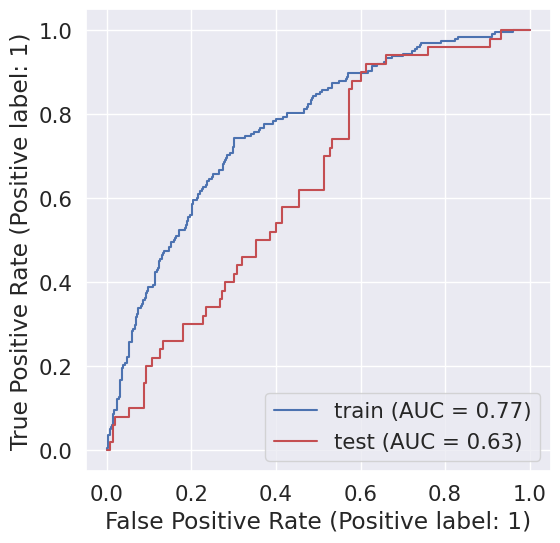

In [350]:
fig, ax = plt.subplots(figsize=(6,6))
display = RocCurveDisplay.from_estimator(lr, X_train, y_train, ax=ax, name='train', color='b')
display = RocCurveDisplay.from_estimator(lr, X_test, y_test, ax=ax, name='test', color='r')
plt.show()

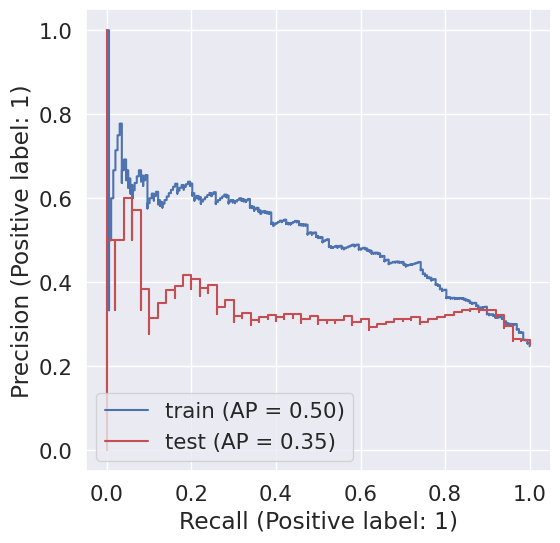

In [351]:
fig, ax = plt.subplots(figsize=(6,6))
display = PrecisionRecallDisplay.from_estimator(lr, X_train, y_train, ax=ax, name='train', color='b')
display = PrecisionRecallDisplay.from_estimator(lr, X_test, y_test, ax=ax, name='test', color='r')
plt.show()

# Dynamic Threshold

In [195]:
def dynamic_threshold_method(X: pd.DataFrame, y: pd.DataFrame, test_ratio=0.2, random_state=None, proba_threshold=0.5):

    hs_count_and_avg_score_per_user = X.groupby('user_id').agg(
        avg_hs_score=("predictions", "mean"),
        hs_count=("predictions", lambda p: get_hs_count(p, proba_threshold)))

    y_train, y_test = train_test_split(y, test_size=test_ratio, random_state=random_state, stratify=y)
    X_train = hs_count_and_avg_score_per_user.loc[y_train.index]
    X_test = hs_count_and_avg_score_per_user.loc[y_test.index]
    print(f'Train Percent HS Users: {y_train.mean()}')
    print(f'Test Percent HS Users: {y_test.mean()}')

    def calc_soft_threshold(arr, lower_bound, higher_bound, low_th, medium_th, high_th):
        return arr[:, 1] >= np.where(arr[:, 0] < lower_bound, high_th, np.where(arr[:, 0] < higher_bound, medium_th, low_th))

    def objective(trial):
        lower_bound = trial.suggest_float("lower_bound", 0.01, 0.15)
        higher_bound = trial.suggest_float("higher_bound", lower_bound + 0.01, 0.3)
        low_th = trial.suggest_int("low_th", 1, np.percentile(X_train['hs_count'].values, 20).astype(int)+1)
        medium_th = trial.suggest_int("medium_th", low_th+1, np.percentile(X_train['hs_count'].values, 40).astype(int)+1)
        high_th = trial.suggest_int("high_th", medium_th + 1, np.percentile(X_train['hs_count'].values, 60).astype(int)+1)

        c0 = float(0.01 + lower_bound - higher_bound)
        c1 = float(1 + medium_th - high_th)
        c2 = float(1 + low_th - medium_th)

        # Store the constraints as user attributes so that they can be restored after optimization.
        trial.set_user_attr("constraint", (c0, c1, c2))

        y_pred = calc_soft_threshold(X_train.values, lower_bound, higher_bound, low_th, medium_th, high_th)

        f1 = f1_score(y_train, y_pred)
        return f1

    def constraints(trial):
        return trial.user_attrs["constraint"]

    sampler = optuna.samplers.NSGAIISampler(
        constraints_func=constraints
    )
    study = optuna.create_study(
        direction='maximize',
        sampler=sampler,
    )
    study.optimize(objective, n_trials=5000, show_progress_bar=True)
    best_f1 = study.best_value
    logger.info(f"Max f1-score: {best_f1}")

    # y_true = test_g_df["label"].values
    y_pred = calc_soft_threshold(X_test.values, **study.best_params)
    print(study.best_params)
    print(best_f1, f1_score(y_test, y_pred))

In [205]:
dynamic_threshold_method(X, y, proba_threshold=0.5)

Train Percent HS Users: 0.15375
Test Percent HS Users: 0.155


100%|██████████| 5000/5000 [01:05<00:00, 76.72it/s] 

2023-02-13 23:59:05,681 - INFO     - user_level_simple_models - Max f1-score: 0.5161290322580645
{'lower_bound': 0.07279273284035742, 'higher_bound': 0.2976304463903019, 'low_th': 2, 'medium_th': 20, 'high_th': 81}
0.5161290322580645 0.543859649122807


# Run Experiment

In [7]:
user_level_execution_config

{'trained_data': 'parler', 'inference_data': 'parler'}

In [6]:
dataset = user_level_execution_config["inference_data"]
logger.info(f"executing dataset {dataset}...")
model_name = post_level_execution_config["kwargs"]["model_name"] # 'BertFineTuning' # post_level_execution_config["kwargs"][args.model] # new_bert_fine_tuning
user2pred = pd.read_parquet(f"detection/outputs/{dataset}/{model_name}/user_level/split_by_posts/no_text/")
user2pred['user_id'] = user2pred['user_id'].astype(int)
user2label_path = user_level_conf[dataset]["data_path"]
sep = ","
if user2label_path.endswith("tsv"):
    sep = "\t"
y = pd.read_csv(user2label_path, sep=sep, index_col=[0]).squeeze()
# user2pred = user2pred[user2pred['user_id'].isin(labeled_users.index)]
X = user2pred[user2pred['user_id'].isin(y.index)]
seed = random.randrange(2 ** 32)
# seed = 2334642105 #42 #338761188

predictions_output_path = os.path.join(post_level_execution_config["evaluation"]["output_path"], 'predictions.tsv')
predictions_df = pd.read_csv(predictions_output_path, sep='\t')
y_true = predictions_df['y_true']
y_prob = predictions_df['y_score']
y_pred = predictions_df['y_pred']

print("Seed is:", seed)
# for method in args.methods:
#     method(X, y, dataset=dataset
# fixed_threshold_num_of_posts(user2pred, labeled_users, output_path, dataset, test_ratio=0.2, random_state=seed)
# relational_threshold(user2pred, labeled_users, output_path, dataset, test_ratio=0.2, random_state=seed)
# dynamic_threshold_hs_score(user2pred, labeled_users, output_path, test_ratio=0.2, random_state=seed)

2023-02-22 20:02:03,665 - INFO     - user_level_simple_models - executing dataset parler...


ValueError: invalid literal for int() with base 10: 'Rob0303'

In [400]:
optimal_threshold(y_true, y_prob)

0.35367036

In [141]:
post_threshold = optimal_threshold(y_true, y_prob)
user_hs_count = user2pred.set_index('user_id').eval('`predictions`>@post_threshold').groupby('user_id').sum().rename('hs_count')

In [127]:
user_mean_preds = user2pred.groupby('user_id').predictions.mean().rename('mean_preds')